In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso,Ridge,BayesianRidge
import lightgbm as lgb
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn
import mxnet as mx
import seaborn as sns
import matplotlib.pyplot as plt
class Processing():
    #特征处理中会用到
    def produce_fee_rate(self,train_data):
            train_data['当前费用稳定性']=train_data['用户账单当月总费用（元）']/(train_data['用户近6个月平均消费值（元）']+1)
            train_data['用户余额比例']=train_data['用户账单当月总费用（元）']/(train_data['用户当月账户余额（元）']+1)
            return train_data
    #特征处理中会用到
    def produce_offline_feature(self,train_data):
            train_data['不同充值途径']=0
            train_data['不同充值途径'][(train_data['缴费用户最近一次缴费金额（元）']%10==0)&train_data['缴费用户最近一次缴费金额（元）']!=0]=1
            return train_data
    #特征处理中会用到
    def func_pro(self,train_test,col1,col2):
            col1_list = train_test[col1].tolist()
            col2_list = train_test[col2].tolist()
            pro_list = []
            for i in range(len(col1_list)):
                if col2_list[i] == 0:
                    pro_list.append(0)
                else:
                    pro_list.append(col1_list[i]/col2_list[i])
            return pro_list
        
     
    #特征处理----本部分输出特征用于进行线性回归、贝叶斯岭回归、前馈神经网络等模型的训练
    #输入：原始数据存储路径
    #输出：特征处理后的数据（dataframe格式）及 特征列表
    
    def feature_engineer_1(self,path):
        train_test = pd.read_csv(path)
        #年龄特征处理及拓展
        train_test.loc[train_test['用户年龄']==0,'用户年龄']  = train_test['用户年龄'].mode()
        train_test['用户入网年龄'] = train_test['用户年龄'] - (train_test['用户网龄（月）']/12)
        train_test['用户入网年龄'] = train_test['用户入网年龄'].map(lambda x: 0 if x<=0 else x)
        #消费特征拓展及处理
        train_test.loc[train_test['缴费用户最近一次缴费金额（元）']==0,'缴费用户最近一次缴费金额（元）']  = train_test['缴费用户最近一次缴费金额（元）'].mode()
        train_test.loc[train_test['缴费用户最近一次缴费金额（元）']==0,'缴费用户最近一次缴费金额（元）']  = train_test['缴费用户最近一次缴费金额（元）'].mode()
        train_test['用户上次缴费前欠费多少']  = train_test['缴费用户最近一次缴费金额（元）'] - train_test['用户账单当月总费用（元）'] - train_test['用户当月账户余额（元）']
        train_test['最近一次缴费比当月总费用多多少'] = train_test['缴费用户最近一次缴费金额（元）'] - train_test['用户账单当月总费用（元）']
        train_test = self.produce_fee_rate(train_test)
        train_test['该月用该户平均通话消费金额'] = train_test['用户账单当月总费用（元）']/train_test['当月通话交往圈人数']
        train_test = self.produce_offline_feature(train_test)
        train_test['是否出入高端商城'] = train_test['当月是否逛过福州仓山万达']+train_test['当月是否到过福州山姆会员店']
        train_test['是否出入高端商城'] = train_test['是否出入高端商城'].apply(lambda x:min(x,1))
        train_test = train_test.drop(columns='当月是否逛过福州仓山万达',axis=1)
        train_test = train_test.drop(columns='当月是否到过福州山姆会员店',axis=1)
        train_test['当月是否进行娱乐休闲活动'] = train_test['当月是否看电影']+train_test['当月是否景点游览']+train_test['当月是否体育场馆消费']
        train_test['当月是否进行娱乐休闲活动'] = train_test['当月是否进行娱乐休闲活动'].apply(lambda x:min(x,1))
        train_test = train_test.drop(columns='当月是否看电影',axis=1)
        train_test = train_test.drop(columns='当月是否景点游览',axis=1)
        train_test = train_test.drop(columns='当月是否体育场馆消费',axis=1)
        train_test['当月视频资讯类应用使用次数'] = train_test['当月视频播放类应用使用次数']+train_test['当月旅游资讯类应用使用次数']
        train_test['当月出行类应用使用次数'] = train_test['当月火车类应用使用次数'] + train_test['当月飞机类应用使用次数']
        train_test['各类应用使用总次数'] = train_test['当月出行类应用使用次数']+train_test['当月金融理财类应用使用总次数']+train_test['当月网购类应用使用次数']+train_test['当月视频资讯类应用使用次数']+train_test['当月物流快递类应用使用次数']
        train_test['逛商场次数-逛淘宝次数'] =  train_test['当月网购类应用使用次数'] - train_test['近三个月月均商场出现次数'] 
        for i in ['当月出行类应用使用次数','当月金融理财类应用使用总次数','当月网购类应用使用次数','当月视频资讯类应用使用次数','当月物流快递类应用使用次数']:
            i_name = i+'_占比'
            train_test[i_name] = train_test[i]/train_test['各类应用使用总次数']

        l1 = self.func_pro(train_test,'当月飞机类应用使用次数','当月出行类应用使用次数')
        l2 = self.func_pro(train_test,'当月旅游资讯类应用使用次数','当月视频资讯类应用使用次数')
        train_test['飞机类出行应用使用占比'] = l1
        train_test['旅游资讯占比'] = l2
        features = train_test.columns.tolist()
        features.remove('用户编码')
        features.remove('信用分')
        train_test[features] = train_test[features].fillna(train_test[features].mode())
        
        
        #连续特征处理+分类特征onehot
        continueFeatures = [ '用户年龄','用户网龄（月）', '缴费用户最近一次缴费金额（元）', '用户近6个月平均消费值（元）', '用户账单当月总费用（元）', 
         '用户当月账户余额（元）',  '当月通话交往圈人数', '近三个月月均商场出现次数', '当月网购类应用使用次数', '当月物流快递类应用使用次数', '当月金融理财类应用使用总次数', 
         '当月视频播放类应用使用次数', '当月飞机类应用使用次数', '当月火车类应用使用次数', '当月旅游资讯类应用使用次数', '用户入网年龄', '用户上次缴费前欠费多少', '最近一次缴费比当月总费用多多少', '当前费用稳定性', '用户余额比例', '该月用该户平均通话消费金额',
          '当月视频资讯类应用使用次数', '当月出行类应用使用次数', '各类应用使用总次数', '逛商场次数-逛淘宝次数', '当月出行类应用使用次数_占比', '当月金融理财类应用使用总次数_占比', '当月网购类应用使用次数_占比', 
         '当月视频资讯类应用使用次数_占比', '当月物流快递类应用使用次数_占比', '飞机类出行应用使用占比', '旅游资讯占比']

        classFeatures = []
        for f in features:
            if f not in continueFeatures:
                classFeatures.append(f)

        train_test[continueFeatures] = train_test[continueFeatures].fillna( train_test[continueFeatures].mean())


        for f in continueFeatures:
            if train_test[f].describe().min()<0:
                min_no = train_test[f].describe().min()
                train_test[f] = train_test[f].apply(lambda x :x-min_no)
            if f not in ['用户年龄','用户网龄（月）','用户入网年龄']:
                train_test[f] = train_test[f].apply(lambda x:np.log1p(x))
                
        dummies_arr = OneHotEncoder(sparse=False).fit_transform(train_test[classFeatures])
        dummies_features = []
        for i in range(dummies_arr.shape[1]):
            dummies_features.append('classFeature_'+str(i))
            train_test['classFeature_'+str(i)] = dummies_arr[:,i]

        new_features = continueFeatures+dummies_features
        return train_test,new_features
        

    #特征处理----本部分输出特征可用于进行LGB的迭代提升树训练
    #输入：原始数据存储路径
    #输出：特征处理后的数据（dataframe格式）及 特征列表(包含总体特征和分类特征)
    
    def feature_engineer_2(self,path):
        train_test = pd.read_csv(path)
        #年龄特征处理及拓展
        train_test.loc[train_test['用户年龄']==0,'用户年龄']  = train_test['用户年龄'].mode()
        train_test['用户入网年龄'] = train_test['用户年龄'] - (train_test['用户网龄（月）']/12)
        train_test['用户入网年龄'] = train_test['用户入网年龄'].map(lambda x: 0 if x<=0 else x)
        #消费特征拓展及处理
        train_test.loc[train_test['缴费用户最近一次缴费金额（元）']==0,'缴费用户最近一次缴费金额（元）']  = train_test['缴费用户最近一次缴费金额（元）'].mode()
        train_test.loc[train_test['缴费用户最近一次缴费金额（元）']==0,'缴费用户最近一次缴费金额（元）']  = train_test['缴费用户最近一次缴费金额（元）'].mode()
        train_test['用户上次缴费前欠费多少']  = train_test['缴费用户最近一次缴费金额（元）'] - train_test['用户账单当月总费用（元）'] - train_test['用户当月账户余额（元）']
        train_test['最近一次缴费比当月总费用多多少'] = train_test['缴费用户最近一次缴费金额（元）'] - train_test['用户账单当月总费用（元）']
        train_test = self.produce_fee_rate(train_test)
        train_test['该月用该户平均通话消费金额'] = train_test['用户账单当月总费用（元）']/train_test['当月通话交往圈人数']
        train_test = self.produce_offline_feature(train_test)
        train_test['是否出入高端商城'] = train_test['当月是否逛过福州仓山万达']+train_test['当月是否到过福州山姆会员店']
        train_test['是否出入高端商城'] = train_test['是否出入高端商城'].apply(lambda x:min(x,1))
        train_test = train_test.drop(columns='当月是否逛过福州仓山万达',axis=1)
        train_test = train_test.drop(columns='当月是否到过福州山姆会员店',axis=1)
        train_test['当月是否进行娱乐休闲活动'] = train_test['当月是否看电影']+train_test['当月是否景点游览']+train_test['当月是否体育场馆消费']
        train_test['当月是否进行娱乐休闲活动'] = train_test['当月是否进行娱乐休闲活动'].apply(lambda x:min(x,1))
        train_test = train_test.drop(columns='当月是否看电影',axis=1)
        train_test = train_test.drop(columns='当月是否景点游览',axis=1)
        train_test = train_test.drop(columns='当月是否体育场馆消费',axis=1)
        train_test['当月视频资讯类应用使用次数'] = train_test['当月视频播放类应用使用次数']+train_test['当月旅游资讯类应用使用次数']
        train_test['当月出行类应用使用次数'] = train_test['当月火车类应用使用次数'] + train_test['当月飞机类应用使用次数']
        train_test['各类应用使用总次数'] = train_test['当月出行类应用使用次数']+train_test['当月金融理财类应用使用总次数']+train_test['当月网购类应用使用次数']+train_test['当月视频资讯类应用使用次数']+train_test['当月物流快递类应用使用次数']
        train_test['逛商场次数-逛淘宝次数'] =  train_test['当月网购类应用使用次数'] - train_test['近三个月月均商场出现次数'] 
        for i in ['当月出行类应用使用次数','当月金融理财类应用使用总次数','当月网购类应用使用次数','当月视频资讯类应用使用次数','当月物流快递类应用使用次数']:
            i_name = i+'_占比'
            train_test[i_name] = train_test[i]/train_test['各类应用使用总次数']

        l1 = self.func_pro(train_test,'当月飞机类应用使用次数','当月出行类应用使用次数')
        l2 = self.func_pro(train_test,'当月旅游资讯类应用使用次数','当月视频资讯类应用使用次数')
        train_test['飞机类出行应用使用占比'] = l1
        train_test['旅游资讯占比'] = l2
        features = train_test.columns.tolist()
        features.remove('用户编码')
        features.remove('信用分')
        train_test[features] = train_test[features].fillna(train_test[features].mode())
        
        continueFeatures = [ '用户年龄','用户网龄（月）', '缴费用户最近一次缴费金额（元）', '用户近6个月平均消费值（元）', '用户账单当月总费用（元）', 
         '用户当月账户余额（元）',  '当月通话交往圈人数', '近三个月月均商场出现次数', '当月网购类应用使用次数', '当月物流快递类应用使用次数', '当月金融理财类应用使用总次数', 
         '当月视频播放类应用使用次数', '当月飞机类应用使用次数', '当月火车类应用使用次数', '当月旅游资讯类应用使用次数', '用户入网年龄', '用户上次缴费前欠费多少', '最近一次缴费比当月总费用多多少', '当前费用稳定性', '用户余额比例', '该月用该户平均通话消费金额',
          '当月视频资讯类应用使用次数', '当月出行类应用使用次数', '各类应用使用总次数', '逛商场次数-逛淘宝次数', '当月出行类应用使用次数_占比', '当月金融理财类应用使用总次数_占比', '当月网购类应用使用次数_占比', 
         '当月视频资讯类应用使用次数_占比', '当月物流快递类应用使用次数_占比', '飞机类出行应用使用占比', '旅游资讯占比']

        classFeatures = []
        for f in features:
            if f not in continueFeatures:
                classFeatures.append(f)
            
        return train_test,features,classFeatures 

In [7]:
class TrainModels():
    #线形模型
    def _linear_regression(self,x_train,y_train):
        linear_regression = LinearRegression()
        linear_regression.fit(x_train,y_train)
        return linear_regression
    def _lasso_regression(self,x_train,y_train):
        lasso_regression = Lasso()
        lasso_regression.fit(x_train,y_train)
        return lasso_regression
    def _ridge_regression(self,x_train,y_train):
        ridge = Ridge()
        ridge.fit(x_train,y_train)
        return ridge
    def _bayesian_ridge_regression(self,x_train,y_train):
        bayesian_ridge = BayesianRidge()
        bayesian_ridge.fit(x_train,y_train)
        return bayesian_ridge
    
    
    #非线性模型---前馈神经网络,需要调参
    def _nn_regression(self,x_train,y_train):
        train_features = nd.array(x_train.values)
        train_labels = nd.array(y_train).reshape((-1, 1))
        loss = gloss.L2Loss()
        net = nn.Sequential()
        net.add(nn.Dense(20, activation='relu'),nn.Dense(1))
        net.initialize(init=mx.init.Normal(sigma=1))
        lr,num_epochs,batch_size = 0.001,800,32
        train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
        # 这里使用了Adam优化算法
        trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
        for epoch in range(num_epochs):
            for X, y in train_iter:
                with autograd.record():
                    l = loss(net(X), y)
                l.backward()            
                trainer.step(batch_size)
        return net
    
    #非线性模型---lightGBM，如果想要达到好的效果需要略微调整参数
    def _lgb_regression(self,x_train,y_train,features,classFeatures):
        train_data = lgb.Dataset(x_train.values, label=y_train, feature_name=features,categorical_feature=classFeatures)
        params1 = {
                'min_data_in_leaf':50,
                'learning_rate': 0.005,
                'boosting_type': 'gbdt',
                'objective': 'regression_l1',
                'metric': 'mae',
                'feature_fraction': 0.66,
                'bagging_fraction': 0.8,
                'bagging_freq': 2,
                'num_leaves': 42,
                'verbose': -1,
                'max_depth': 6,
                'lambda_l2': 5, 'lambda_l1': 1, 'nthread': 8,
                'seed': 89
            }
        no = 7000
        lgb_model1 = lgb.train(params1, train_data,num_boost_round=no)
        return lgb_model1

/Users/xiadanqing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/xiadanqing/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


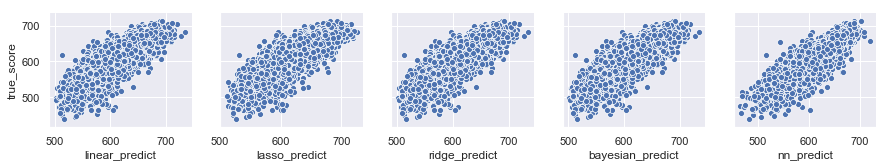

/Users/xiadanqing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/xiadanqing/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [8]:
if __name__ == "__main__":
    path = '/Users/xiadanqing/Desktop/newLand/train_dataset.csv'
    data_module = Processing()
    model_module = TrainModels()
    train_test,features = data_module.feature_engineer_1(path)
    x_train,x_test,y_train,y_test = train_test_split(train_test[features],train_test['信用分'],test_size = 0.2,random_state=2019)
    #线形回归
    linear_model = model_module._linear_regression(x_train,y_train)
    linear_predict = linear_model.predict(x_test).tolist()
    #lasso回归
    lasso_model = model_module._lasso_regression(x_train,y_train)
    lasso_predict = lasso_model.predict(x_test).tolist()
    #岭回归
    ridge_model = model_module._ridge_regression(x_train,y_train)
    ridge_predict = ridge_model.predict(x_test).tolist()
    #贝叶斯岭回归
    bayesian_model = model_module._bayesian_ridge_regression(x_train,y_train)
    bayesian_predict = bayesian_model.predict(x_test).tolist()
    #含有一层隐含层的前馈神经网络回归
    net = model_module._nn_regression(x_train,y_train)
    test_features = nd.array(x_test.values)
    nn_predict = net(test_features).asnumpy().reshape(1, -1)[0]
    nn_predict = nn_predict.tolist()
    
    #########用于可视化展示#################
    show_1 = pd.DataFrame()
    show_1['true_score'] = y_test.tolist()
    show_1['linear_predict'] = linear_predict
    show_1['lasso_predict'] = lasso_predict
    show_1['ridge_predict'] = ridge_predict
    show_1['bayesian_predict'] = bayesian_predict
    show_1['nn_predict'] = nn_predict
    x_list = ['linear_predict','lasso_predict','ridge_predict','bayesian_predict','nn_predict']
    sns.set()
    sns.pairplot(show_1,x_vars=x_list,y_vars=['true_score'],size = 2.5)
    plt.show();
    #####################################
    #lightgbm回归-----lgb可以通过制定category-features的方式来免除对类别特征进行one-hot编码，且不需对自变量进行log等操作，可以说是非常方便了
    #另外实验证明---lgb的效果很好（下图可视化虽然测试数据集选取不同，但可以尝试划分相同的数据集合来测试，会发现这是很吼的）
    train_test,features,classFeatures = data_module.feature_engineer_2(path)
    x_train,x_test,y_train,y_test = train_test_split(train_test[features],train_test['信用分'],test_size = 0.2,random_state=2019)
    lgb_model = model_module._lgb_regression(x_train,y_train,features,classFeatures)
    lgb_predict = lgb_model.predict(x_test).tolist()
    ##########用于可视化展示#################
    show_2 = pd.DataFrame()
    show_2['true_score'] = y_test.tolist()
    show_2['lgb_predict'] = lgb_predict
    #######################################

/Users/xiadanqing/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


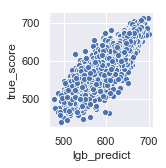

In [9]:
sns.set()
sns.pairplot(show_2,x_vars=['lgb_predict'],y_vars=['true_score'],size = 2.5)
plt.show();